In [2]:
## load libraries
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
import cmath as cm
from scipy import signal as sps
from IPython.display import HTML

# Temporal Vs. Spectral Space
In order to understand filtering, it is helpful to see signals as frequency components.
## Fourier Series
The Fourier series is a series of harmonically linked (all frequencies are a multiple of the lowest frequency) sinusoids that, once weighted and summed, are equivalent to an arbitrary signal for the period of the fundamental (ie. the lowest frequency present in the signal. Or, if the signal is of a determined length, one over the length of said signal).

To illustrate this, let us decompose a square wave signal at 440Hz with a duty cycle of 50%; a periodic signal oscillating  from +1 to -1 440 times per second where exactly half of the signal is positive  and half is negative.

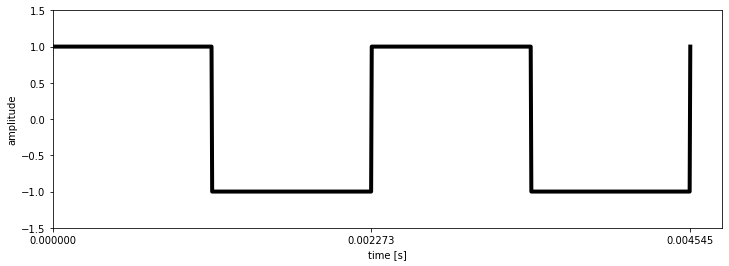

In [3]:
#This is the fundamental frequency. This is also the frequency of the first component.
fundamental = 440 
# Compute time and waveform data points
t = np.linspace(0,2/fundamental,1000);
x = sps.square(2*np.pi*440*t,0.5);
# show the waveform
fig, ax = plt.subplots(1,1,figsize=(12,4),sharex='col');

# Make the axes look nice
ax.axis([0,2.1/fundamental,-1.5,1.5]);
ax.set_xlabel('time [s]')
ax.set_ylabel('amplitude')
ax.set_xticks(np.arange(3)/fundamental)

# Draw the waveform
l1, = ax.plot(t,x,lw=4,color='k');

The Fourier series for square waveform $f(t)$ is computed as:
\begin{equation}
    f(x) = {4\over\pi}\sum_{n=1,3,5,\ldots}^{\infty}{1 \over n} sin({n \pi t \over T})
\end{equation}
In English, this means that the series is composed of all the odd components (since ${n=1,3,5,\ldots,\infty}$), where each is multiplied by $1/n$ (components get smaller and smaller) and the sum of the components is then multiplied by $4/\pi$ (ie. a bit over 1). This Formula derives from the Fourier transform, which allows to analytically decompose a signal into its Fourier series. This transform is not explained here; Imagine a blackbox operation that converts a linear equation into a sum of frequency components. In real world application algorithms such as the fast Fourier transform (FFT) are used, which are very good at approximating the discrete (ie. digital) Fourier transform.

In [4]:
# Compute The Fourier series components
# Nframes determines how many frames the animation will have 
# each frame will add one more component, hence the number of
# frames is also the number of components to be computed
Nframes = 10;
# Set up empty line to accept the series' data
l2, = ax.plot([],[],lw=4,color='b');
# Set up empty lines to accept the components data
lines = [ax.plot([],[]) for _ in range(Nframes)];

# Add textual information on root mean square deviation
# and number of components
text = ax.text(0.0002,-1,"RMSD = {:.3}\n # of components = {:}".format(np.sqrt(np.mean(np.square(x))),0));

# Compute the components according to equation above
x_components = [4/np.pi*1/n*np.sin(2*np.pi*fundamental*n*t) for n in range(1,Nframes*2+1,2)];

# Define animation update function
def animate(i):
    # at frame 0, remove all components
    if i==0:
        for line in lines:
            line[0].set_data([],[]);
    #recompute the fourier series to the ith component
    x_series = sum(x_components[0:(i+1)],0);
    # plot series
    l2.set_data(t,x_series);
    # add new component to graph
    lines[i][0].set_data(t,x_components[i]);
    # update text
    x_rmsd = np.sqrt(np.mean(np.square(x-x_series)));
    text.set_text("RMSD = {:.3}\n # of components = {:>}".format(x_rmsd,i+1));
    
# Create animation object
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=Nframes, interval = 500);
# Run animation
HTML(ani.to_jshtml())

As the number of components increases, the series approximates the original better and better. The *root mean square deviation* (an indicator of the quality of the fit, lower is better) decreases in a logarithmic way. 

## Spectral representation
No, spectral has nothing to do with ghosts. The specter (or spectrum) of a signal is it's frequency signature. Typically, this is represented in the form of a power spectrum density (**PSD**): a frequency vs. power density plot. The amplitude of the specter at a given frequency tells how much of the power is contained at that frequency. Let's look at a few examples for better understanding:

In [5]:
# Initialize variables
# frequency of the periodic signals
f_signal = 4
# sampling rate
sr = 68

# timeseries vector of length 4*T (two periods(T), T = 1/f)
t = np.arange(0,4*1/f_signal,1/sr)

Each signal will be plotted in temporal space on the left and twice in spectral space, once as it's theoretical expression and once using the PSD computed with `scipy`'s `signal.periodogram` function.

### Dirac delta function ($\delta$)
$\delta$ is a very important function for signal processing. It is the input for a so called *impulse response* which helps to characterize electronic systems. It is also frequently present in the spectra of common signals. We will use it several times further down.

The Dirac delta function is defined as:
\begin{equation*}
    \delta(t) = \left\{\begin{matrix}
     +\infty  & if\ t = 0\\ 
     0 & if\ t\neq0 
    \end{matrix}\right.
\end{equation*}
and fulfils the condition
$$
\int_{-\infty}^{\infty}{\delta(t)dt} = 1
$$
In other words, it is a spike with an infinite amplitude, a width of 0 and a surface area of 1. This is of course impossible to use in the digital world, therefore it is expressed as:
\begin{equation*}
    \delta(n) = \left\{\begin{matrix}
     sr  & if\ n = 0\\ 
     0 & if\ n\neq0 
    \end{matrix}\right.
\end{equation*}
where $n$ is the sample number and sr is the sample rate. This creates a square pulse of amplitude sr and of width $1\over sr$. This gives us an area under the curve of $sr \cdot {1\over sr} = 1$.



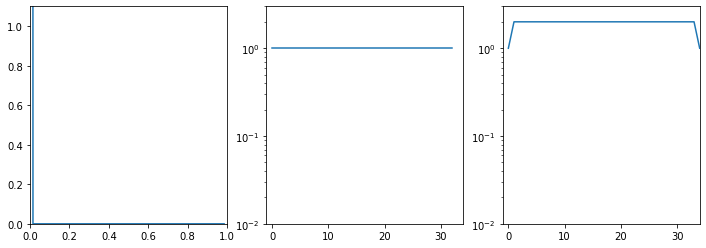

In [6]:
# Initialize figure
from scipy.signal import periodogram
fig, ax = plt.subplots(1,3,figsize=(12,4));
# Direct current(DC)
x = [0 if x !=0 else sr for x in t]
f = [0,32]
X = [1,1]
fp,Xp = periodogram(x,fs=sr,detrend=False)

ax[0].axis([0,1,0,1.1])
ax[0].plot(t,x)
ax[1].axis([-1,sr/2,10**-2,3])
ax[1].plot(f,X)
ax[1].set_yscale('log')
ax[2].axis([-1,sr/2,10**-2,3])
ax[2].plot(fp,Xp)
ax[2].set_yscale('log')

First, let's look at the axes: 
- The amplitude of a periodogram is usually expressed on a logarithmic scale because we are usually interested in order of magnitude differences.
- The frequencies axis ranges from 0 to $sr/2$. This is a convenient amount of data to show since it covers everything below Nyquist's frequency (we'll get to that shortly). It is not the only reason, it has also to do with the use of `scipy.signal.periodogram` and more.

Now let's look at the data. The theoretical PSD would be a constant amplitude of 1 across all frequencies. We see that the periodogram is a bit off, ranging from amplitude 1 to 2. This is because it only got a very short window of data to work with, $\delta$ is supposed to range from $-\infty$ to $+\infty$. But again, we are mostly interested in order of magnitude differences, so a factor of 2 is not that much off.
### Direct current(DC)
Direct current is a signal that remains at a constant (and therefore does not vary over time). It's PSD is entirely concentrated at f=0

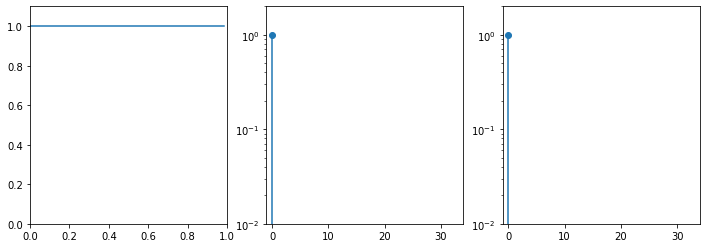

In [7]:
fig, ax = plt.subplots(1,3,figsize=(12,4));

# Direct current(DC)
x = [1 for x in t]
f = [0]
X = [1]
fp,Xp = periodogram(x,fs=sr,detrend=False)

ax[0].axis([0,1,0,1.1])
ax[0].plot(t,x)
ax[1].axis([-1,sr/2,10**-2,2])
ax[1].stem(f,X,use_line_collection=True)
ax[1].set_yscale('log')
ax[2].axis([-1,sr/2,10**-2,2])
ax[2].stem(fp,Xp,use_line_collection=True)
ax[2].set_yscale('log')

The transform of a DC signal is $1 \cdot \delta(0)$, ie. all the power (the  1) is concentrated at f=0Hz. So a DC signal is nothing but a "periodic" signal that does not change in time. It is often called the DC component of a signal. removing the DC component is the same as to center the signal on the non temporal axis such as $\int_{-\infty}^{\infty}{f(t)dt} = 0$. In the code above we run `fp,Xp = periodogram(x,fs=sr,detrend=False)`; the `detrend=False` part preserves the DC component in the periodogram.

### Sinusoid
Let's look at the sin function: $f(t) = A \cdot \sin(\omega\cdot (t + \varphi))+c$ where:
- A is the amplitude
- $\omega$ is the angular speed in radians per second. It is $\omega = 2 \cdot \pi \cdot f$.
- $\varphi$ is the phase. This is equivalent to a shift on the temporal axis.
- c is a constant value, ie. the DC component. It is equivalent to a shift on the amplitude axis.

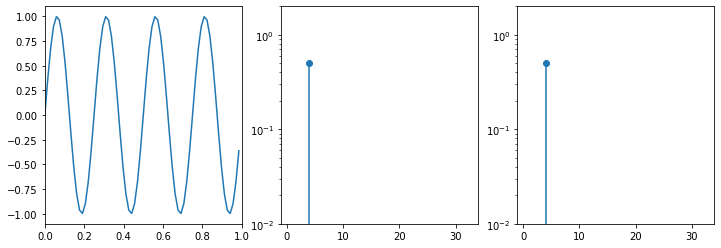

In [9]:
fig, ax = plt.subplots(1,3,figsize=(12,4));
# Sinusoid
x = np.sin(2*np.pi*f_signal*t)
f = [f_signal]
X = [0.5]
fp,Xp = periodogram(x,fs=sr,detrend=False)

ax[0].axis([0,1,-1.1,1.1])
ax[0].plot(t,x)
ax[1].axis([-1,sr/2,10**-2,2])
ax[1].stem(f,X,use_line_collection=True)
ax[1].set_yscale('log')
ax[2].axis([-1,sr/2,10**-2,2])
ax[2].stem(fp,Xp,use_line_collection=True)
ax[2].set_yscale('log')

The transform of a sinusoid is a dirac at the frequency of the sinusoid. This is rather obvious if you consider that what we are representing in the PSD is a series of sin functions that if summed up give the temporal signal. Decomposing a sin will obviously return the sin itself. 

There is something  weird though, it only has amplitude of 0.5. This is because we only see a half truth here (quite literally). A spectrum always runs from $-\infty$ to $+\infty$. In truth, there are two $\delta$ with amplitude 0.5 at $-f_{signal}$ and $f_{signal}$. It is rather common to only represent the positive party of a PSD since the negative part is identical.

### sinc (sine cardinal)
The sinc function is often encountered when switching from temporal to spectral space (and vice versa). it is defined as:
$$
sinc(x) = \left\{\begin{matrix}
 1  & if\ x = 0\\ 
 {\sin(x)\over{x}} & if\ x\neq0 
\end{matrix}\right.
$$
It is also called the sampling function or, very colloquially, the Mexican  hat function because of how it looks. We have to define its value at $x = 0$ to avoid a zero division. This is the definition for the normalized sinc function, we will be using a non normalized version where $x = \omega t$.

For this one we'll use $-1 \le t \le 1$ since the "hat" is centered at $t=0$.

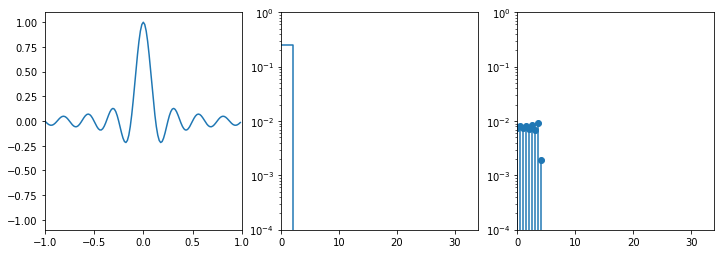

In [10]:
fig, ax = plt.subplots(1,3,figsize=(12,4));
t1 = np.arange(-1,1,1/sr)
x = [np.sin(2*np.pi*f_signal*x)/(2*np.pi*f_signal*x) if x !=0 else 1 for x in t1]
f = [-f_signal/2,f_signal/2,f_signal/2*1.00000000000001,32]
X = [1/f_signal,1/f_signal,0,0]
fp,Xp = periodogram(x,fs=sr,detrend=False,return_onesided=False)

ax[0].axis([-1,1,-1.1,1.1])
ax[0].plot(t1,x)
ax[1].axis([0,sr/2,10**-4,1])
ax[1].plot(f,X)
ax[1].set_yscale('log')
ax[2].axis([0,sr/2,10**-4,1])
ax[2].stem(fp,Xp,use_line_collection=True)
ax[2].set_yscale('log')

The  transform is a square with amplitude $1\over{f_{signal}}$ and width of$f_{signal}$ (remember that half of it is in the negative frequencies). Note that the periodogram is quite off the mark. This is because the width and amplitude actually depend on the sampling frequency.
Interestingly enough, the transform of a square function (not a periodic square wave, a single square pulse) is a sinc.

### square wave 
Finally, let's look at the square wave from the Fourier decomposition above.

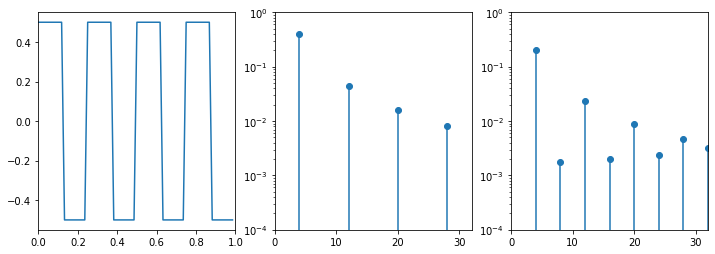

In [11]:
fig, ax = plt.subplots(1,3,figsize=(12,4));
t = np.arange(0,1,1/sr)            

x = sps.square(2*np.pi*f_signal*t,0.5)/2;
f = np.arange(1,int(sr/2))*f_signal
X = np.array([(2/n/np.pi)**2*np.abs(np.sin(n*np.pi/2)) for n in range(1,int(sr/2))]);
fp,Xp = periodogram(x,sr)

ax[0].axis([0,1,-0.55,0.55])
ax[0].plot(t,x)
ax[1].axis([0,32,10**-4,1])
ax[1].stem(f,X,use_line_collection=True);
ax[1].set_yscale('log')
ax[2].axis([0,32,10**-4,1])
ax[2].stem(fp,Xp,use_line_collection=True)
ax[2].set_yscale('log')

The PSD should be a comb of $\delta$ with amplitude $2\over{n \pi}$ for all odd n. Again, the periodogram has a hard time to compute this; the signal is too short and the sampling rate too low.